# Connectivity

One thing that may be bothering you about SIR is the idea of a population where all the possible interactions between individuals take place. You don't meet everyonme in your city, town, or village like that on a regular basis: that isn't how societies work.

Admittedly you get this sort of "complete mixing" in *some* scenarios. A school for young children (or, even better, a toddler's nursery) perhaps works like this as the children go out to play together and everyone mixes with everyone else. And this is why diseases spread so rapidly through nurseries: one sick child will infect all the others.

This phenomenon can be used constructively, and when I was a child it was commonplace for parents to hold "chickpox parties" and bring all the neighbouring children together to play so they could be exposed &ndash; and then subsequently be immune from further infection, since chickenpox is quite well-modelled by SIR [[1]](notes.ipynb#network1).

But in other cases the assumption of complete mixing is going to break down. And since we know that even a small change in infectivity can have a dramatic effect on the progress of an epidemic, can we change SIR to accommodate the social realities in which there are substantially fewer connections between individuals that we might expect?

There are a couple of ways we could answer this question.

Let's return to the equation where all the intreresting stuff happens:

$$
    \Delta I = p_{\mathit{infect}} \, SI - p_{remove} I
$$

The first term essentially takes all the possible contacts (all $S \times I$ of them) and "exposes" them to the $p_{\mathit{infect}}$ factor that decides what proportion of them are infected. If we want fewer contacts to be exposed, we can simply add another factor &ndash; let's call it $x$ for "exposed" &ndash; that determines what proportion of the contacts are taken into consideration. This would lead os to re-write the above equation as:

$$
    \Delta I = p_{\mathit{infect}} \, x \, SI - p_{remove} I
$$

If $x = 0$ then there are no potentially infectious contacts; if $x = 1$ then *all* contacts are potentially infectious and we recover our original equation; and for values of $x$ such that $0 \lt x \lt 1$ we choose the fraction of contacts we want to happen.

# Networks

There is another, more interesting, approach that uses networks, and it's this approach that we'll turn to.

A *network* is simply a collection of *nodes* connected by *edges*. A road map is a good example of a network: the nodes are the road junctions, while the edges (which connect the junctions together) are the segments of roads. This is the reason we sometimes refer to the *road network*: it's a collection of (bits of) road that meet at various points.

Another good example of a network &ndash; and closer to our current application &ndash; is a *social network*. In a social network the nodes are people and the edges are "social links" or "social contacts" between them. While we usually think of social networks as being online, like Facebook or Twitter, they idea works in the real world too: when you meet your family, go shopping, go to work, or indulge in any of the activities of daily life you add edges to your social network between yourself and the people you meet.    

In [9]:
import numpy
import networkx
import epydemic

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import seaborn

In [10]:
def make_sir(beta, alpha):
    # turn the equations into update functions
    def dS(S, I, R):
        return -beta * S * I
    def dI(S, I, R):
        return beta * S * I - alpha * I
    def dR(S, I, R):
        return alpha * I
    
    # return the three functions
    return (dS, dI, dR)

In [11]:
def epidemic_sir(T, N, pInfected, pInfect, pRemove):
    # create the equations for these parameters
    (dS, dI, dR) = make_sir(pInfect, pRemove)
    
    # initial conditions
    sss = [ N * (1.0 - pInfected) ]   # everyone is initially susceptible...
    iss = [ N * pInfected ]           # ...except for this fraction...
    rss = [ 0 ]                       # ...and no-one starts off removed

    # push the initial conditions through the differential equations
    for t in range(1, T):
        ds = dS(sss[-1], iss[-1], rss[-1])
        di = dI(sss[-1], iss[-1], rss[-1])
        dr = dR(sss[-1], iss[-1], rss[-1])
        sss.append(sss[-1] + ds)
        iss.append(iss[-1] + di)
        rss.append(rss[-1] + dr)
        
    # return the time series
    return (list(range(0, T)), sss, iss, rss)

In [17]:
N = 2000
T = 5000
pInfected = 0.01
pRemove = 0.001

In [13]:
class MonitoredSIR(epydemic.SIR, epydemic.Monitor):
    '''A monitored epidemic.'''''
 
    def __init__(self):
        super(MonitoredSIR, self).__init__()
        
    def build(self, params):
        '''Build the observation process.
        
        :param params: the experimental parameters'''
        super(MonitoredSIR, self).build(params)

        # also monitor other compartments
        self.trackNodesInCompartment(epydemic.SIR.SUSCEPTIBLE)
        self.trackNodesInCompartment(epydemic.SIR.REMOVED)

In [14]:
def network_sir(T, g, pInfected, pInfect, pRemove):
    # create the simulator
    m = MonitoredSIR()
    m.setMaximumTime(T)
    e = epydemic.StochasticDynamics(m, g)

    # set the simulation parameters
    param = dict()
    param[epydemic.SIR.P_INFECTED] = pInfected
    param[epydemic.SIR.P_INFECT] = pInfect
    param[epydemic.SIR.P_REMOVE] = pRemove
    param[epydemic.Monitor.DELTA] = T / 100          # take 100 samples
    
    # run the simulation
    rc = e.set(param).run()
    
    # extract the time series
    results = e.experimentalResults()[MonitoredSIR.TIMESERIES]
    ts = results[MonitoredSIR.OBSERVATIONS]
    sss = results[epydemic.SIR.SUSCEPTIBLE]
    iss = results[epydemic.SIR.INFECTED]
    rss = results[epydemic.SIR.REMOVED]

    # return the time series
    return(ts, sss, iss, rss)

In [15]:
g = networkx.complete_graph(N)

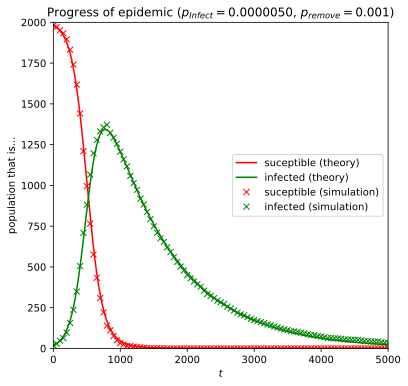

In [29]:
fig = plt.figure(figsize=(6, 6))
ax = fig.gca()

pInfect = 0.000005      # chosen simply for illustration

# run the epidemic equations
#(ts, sss, iss, rss) = epidemic_sir(T, N, pInfected, pInfect, pRemove)
ax.plot(ts, sss, 'r-', label='suceptible (theory)')
ax.plot(ts, iss, 'g-', label='infected (theory)')
#ax.plot(ts, rss, 'k-', label='removed (theory)')

# run the corresponding simulation
#(sim_ts, sim_sss, sim_iss, sim_rss) = network_sir(T, g, pInfected, pInfect, pRemove)
ax.plot(sim_ts, sim_sss, 'rx', label='suceptible (simulation)')
ax.plot(sim_ts, sim_iss, 'gx', label='infected (simulation)')
#ax.plot(sim_ts, sim_rss, 'kx', label='removed (simulation)')

# fine-tune the figure
plt.title('Progress of epidemic ($p_{\\mathit{Infect}} = ' + '{b:.7f}$, '.format(b=pInfect) + '$p_{remove} = ' + '{a}$)'.format(a=pRemove))
ax.set_xlabel('$t$')
ax.set_xlim([0, T])
ax.set_ylabel('population that is...')
ax.set_ylim([0, N])
ax.legend(loc='center right')
plt.savefig('network-same-beta-alpha.png')
plt.show()